# Laboratorium 8. Wizja Komputerowa

**Uwaga:** Poniższy notebook jest stworzony z myślą o uruchamianiu go w [Colaboratory](https://colab.research.google.com/), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [31]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [32]:
import torch
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

Files already downloaded and verified
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


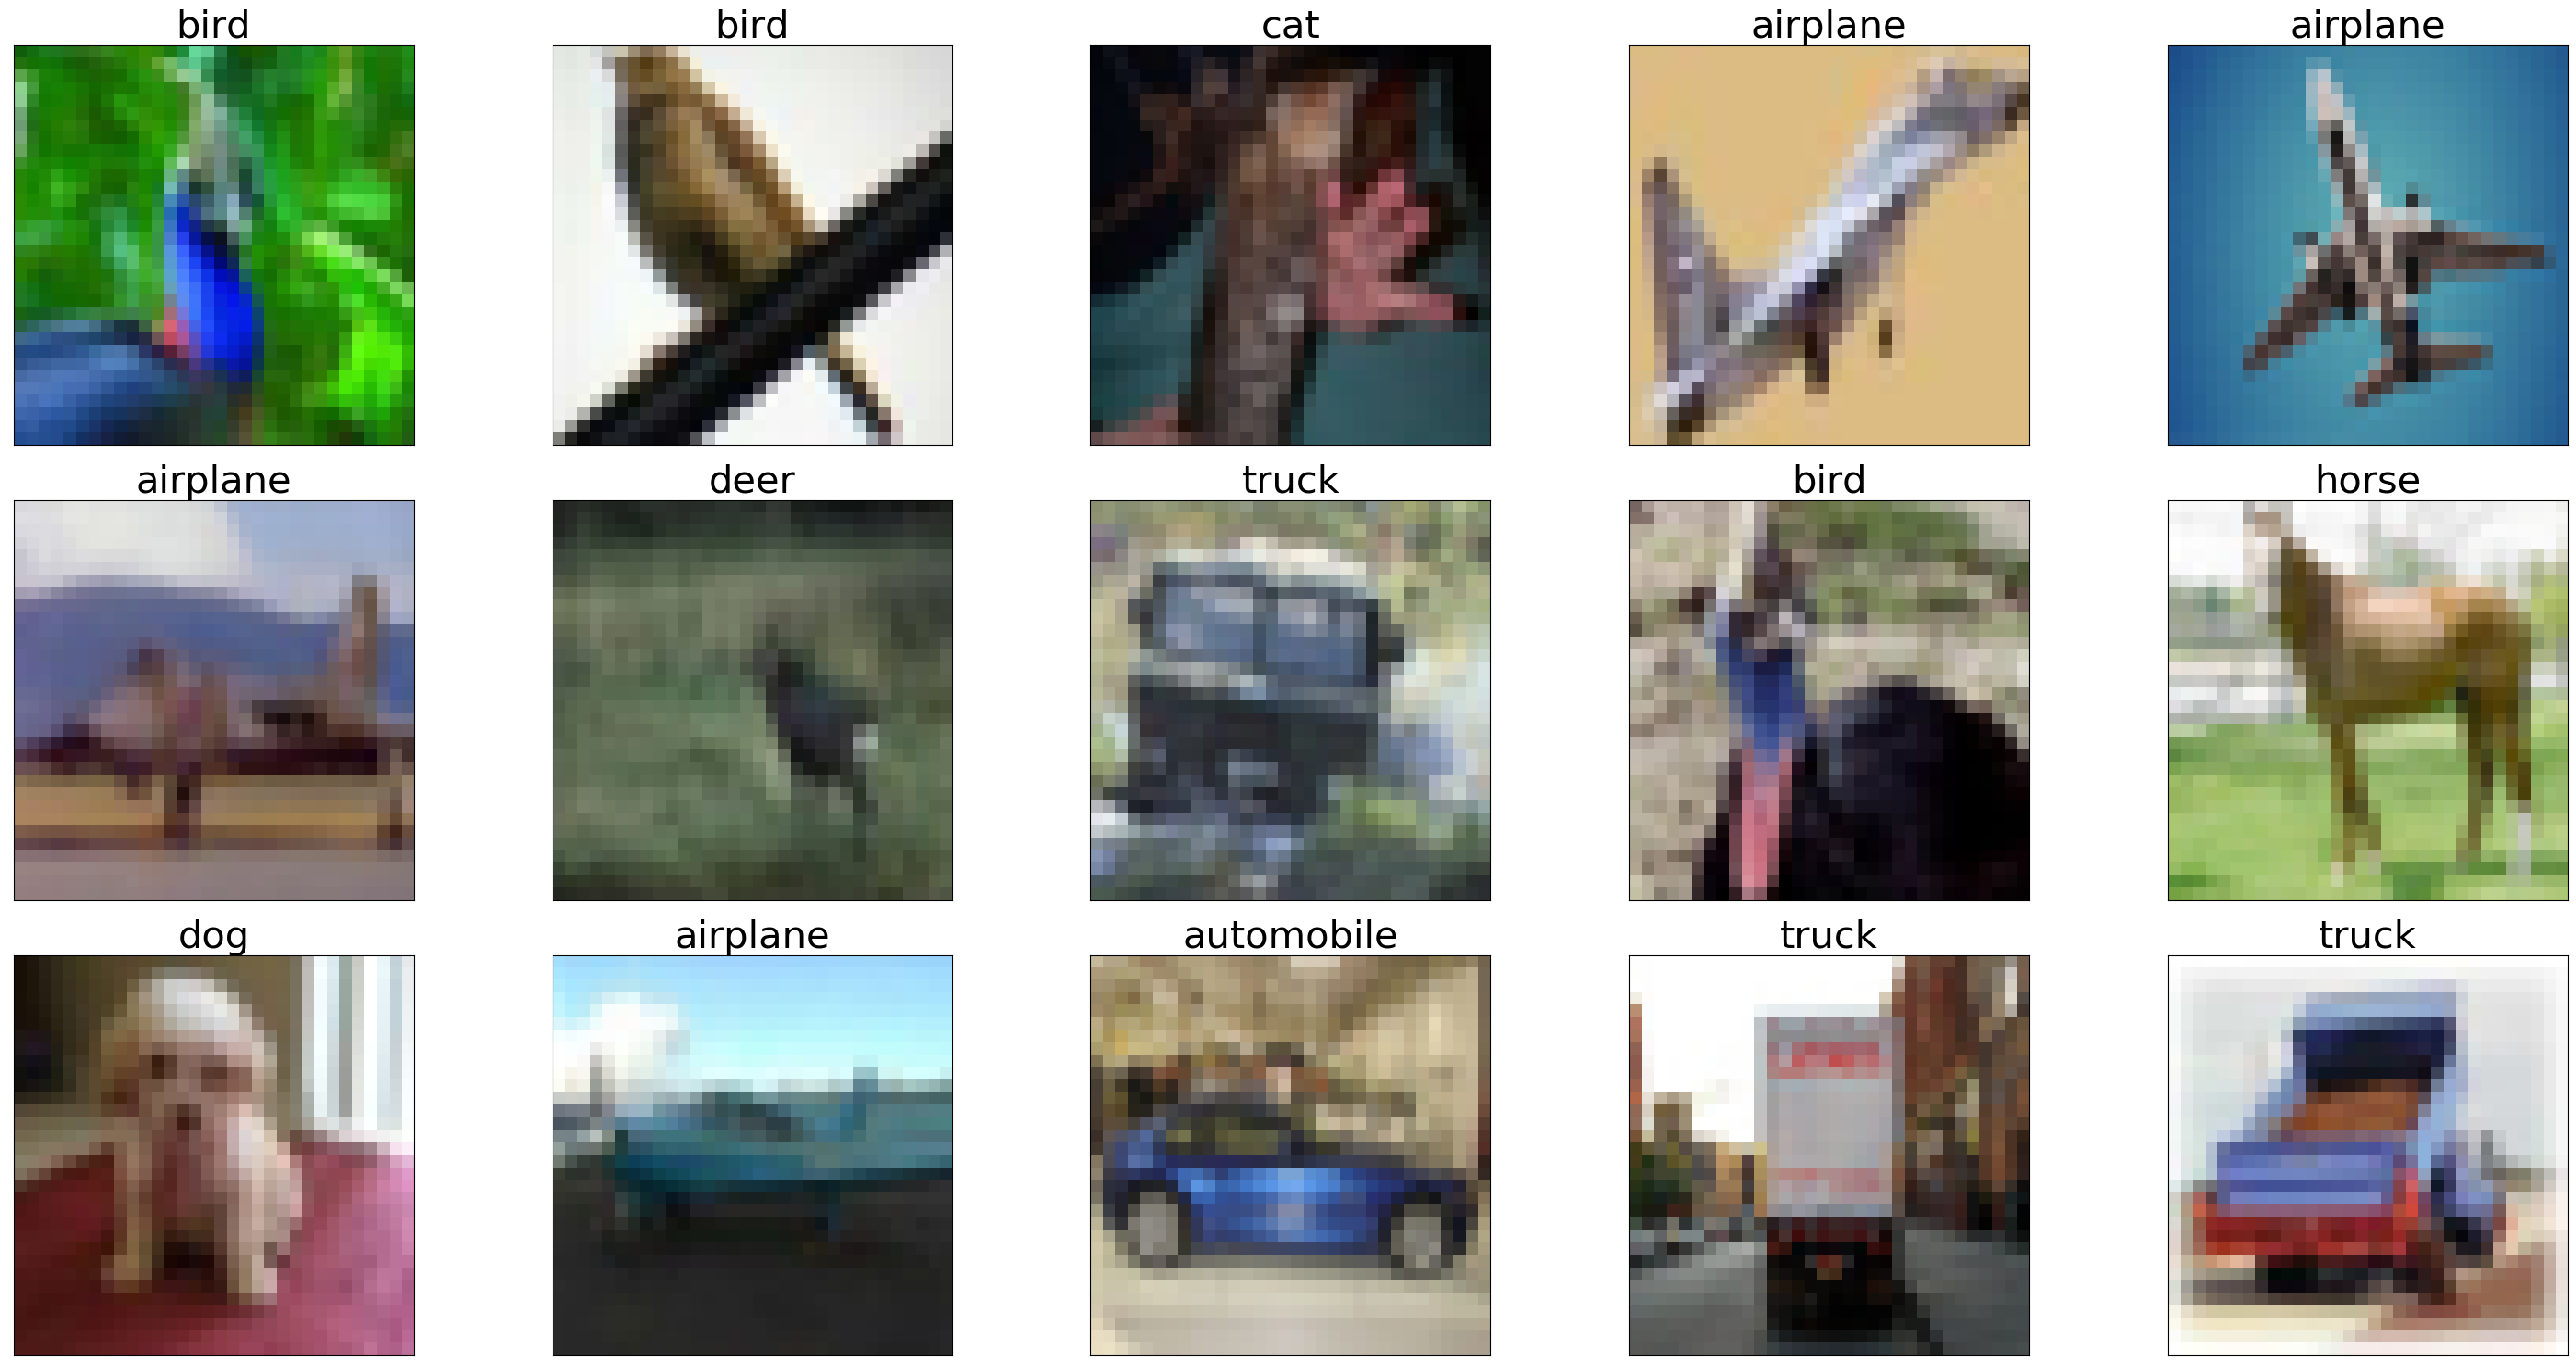

In [33]:
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 1. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [34]:
# tutaj zdefiniuj swój model, nie zapomnij o dziedziczeniu z torch.nn.Module
import torch.nn.functional as F


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()
print(model)# move tensors to GPU if CUDA is available


criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [35]:
# tutaj uzupełnij ładowanie danych treningowych i testowych

transform = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=transform)

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=transform)


train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cpu


In [37]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs): # training our model, put input according to every batch.

  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in train_loader:
    inputs = inputs.to(device) # input to device as our model is running in mentioned device.
    labels = labels.to(device)
    outputs = model(inputs) # every batch of 100 images are put as an input.
    loss = criterion(outputs, labels) # Calc loss after each batch i/p by comparing it to actual labels.

    optimizer.zero_grad() #setting the initial gradient to 0
    loss.backward() # backpropagating the loss
    optimizer.step() # updating the weights and bias values for every single step.

    _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.

  else:
    with torch.no_grad(): # we do not need gradient for validation.
      for val_inputs, val_labels in test_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)

    epoch_loss = running_loss/len(train_loader) # loss per epoch
    epoch_acc = running_corrects.float()/ len(train_loader) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(test_loader)
    val_epoch_acc = val_running_corrects.float()/ len(test_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 2.2991, acc 13.0820 
validation loss: 2.2919, validation acc 14.0900 
epoch : 2
training loss: 2.2583, acc 15.1600 
validation loss: 2.1886, validation acc 19.0500 
epoch : 3
training loss: 2.0788, acc 23.3580 
validation loss: 1.9771, validation acc 28.8500 
epoch : 4
training loss: 1.9095, acc 30.1960 
validation loss: 1.8219, validation acc 33.5700 
epoch : 5
training loss: 1.7581, acc 36.1860 
validation loss: 1.6842, validation acc 38.0300 
epoch : 6
training loss: 1.6487, acc 40.0840 
validation loss: 1.5992, validation acc 41.5700 
epoch : 7
training loss: 1.5771, acc 42.6200 
validation loss: 1.5460, validation acc 43.9200 
epoch : 8
training loss: 1.5245, acc 44.6060 
validation loss: 1.4949, validation acc 46.1200 
epoch : 9
training loss: 1.4774, acc 46.5980 
validation loss: 1.4564, validation acc 47.6000 
epoch : 10
training loss: 1.4378, acc 48.0600 
validation loss: 1.4322, validation acc 48.6900 
epoch : 11
training loss: 1.4004, acc 49.6600 
va

## Augmentacje

Pakiet `torchvision` implementuje wiele różnych transformacji do danych, część z nich jest użyteczna do tzw. augmentacji danych. Augmentacja danych to mechanizm "sztucznego" zwiększania datasetu treningowego poprzez dodawanie do niego zmodyfikowanych kopii danych, które już w nim istnieją. Augmentacja jest szczególnie użyteczna kiedy nasz dataset ma małą liczbę przykładów do uczenia skomplikowanych sieci neuronowych. 

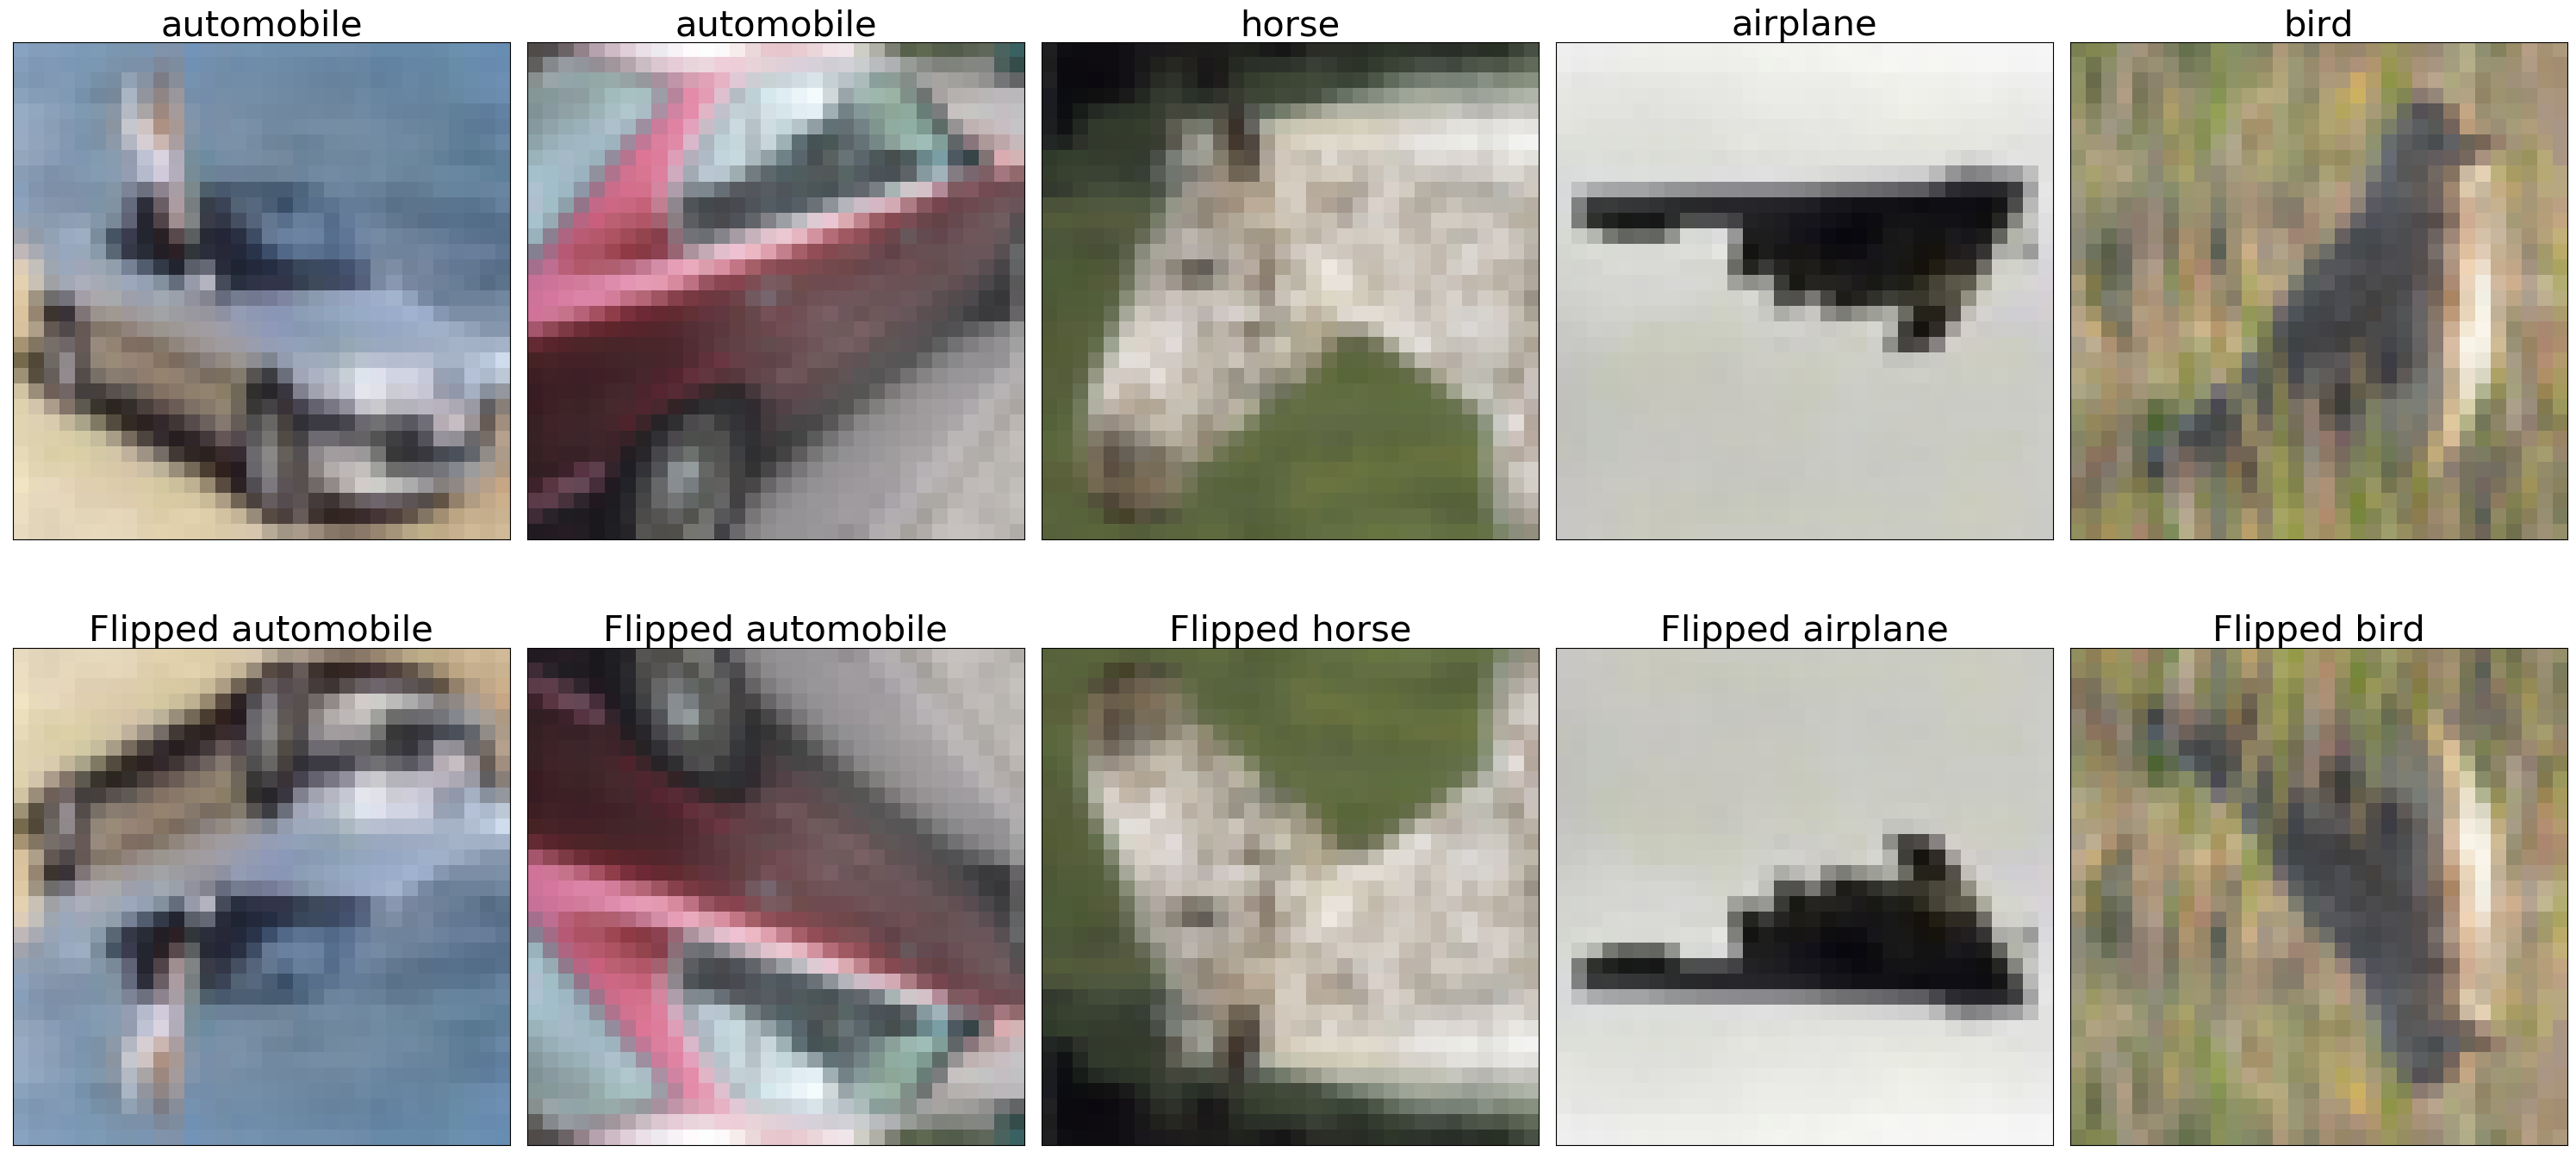

In [38]:
from torchvision.transforms import RandomVerticalFlip

# load test set
dataset = CIFAR10(root='.', train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1) 

# load some data
for x, y in loader:
    break
    

# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])
    
for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 2. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [39]:
from torchvision.transforms import transforms

# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe

transform_train = Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])


transform = transforms.Compose([transforms.Resize((32,32)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=transform_train)

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=transform)


train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs): # training our model, put input according to every batch.

  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in train_loader:
    inputs = inputs.to(device) # input to device as our model is running in mentioned device.
    labels = labels.to(device)
    outputs = model(inputs) # every batch of 100 images are put as an input.
    loss = criterion(outputs, labels) # Calc loss after each batch i/p by comparing it to actual labels.

    optimizer.zero_grad() #setting the initial gradient to 0
    loss.backward() # backpropagating the loss
    optimizer.step() # updating the weights and bias values for every single step.

    _, preds = torch.max(outputs, 1) # taking the highest value of prediction.
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data) # calculating te accuracy by taking the sum of all the correct predictions in a batch.

  else:
    with torch.no_grad(): # we do not need gradient for validation.
      for val_inputs, val_labels in test_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)

    epoch_loss = running_loss/len(train_loader) # loss per epoch
    epoch_acc = running_corrects.float()/ len(train_loader) # accuracy per epoch
    running_loss_history.append(epoch_loss) # appending for displaying
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(test_loader)
    val_epoch_acc = val_running_corrects.float()/ len(test_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    print('epoch :', (e+1))
    print('training loss: {:.4f}, acc {:.4f} '.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc {:.4f} '.format(val_epoch_loss, val_epoch_acc.item()))

epoch : 1
training loss: 1.4070, acc 49.8960 
validation loss: 1.2929, validation acc 2676.0000 
epoch : 2
training loss: 1.3779, acc 51.0160 
validation loss: 1.2778, validation acc 2719.0000 
epoch : 3
training loss: 1.3562, acc 51.8400 
validation loss: 1.2736, validation acc 2729.0000 
epoch : 4
training loss: 1.3391, acc 52.5180 
validation loss: 1.2521, validation acc 2765.5000 
epoch : 5
training loss: 1.3256, acc 53.1220 
validation loss: 1.2359, validation acc 2801.5000 
epoch : 6
training loss: 1.3090, acc 53.6940 
validation loss: 1.2296, validation acc 2806.0000 
epoch : 7
training loss: 1.2939, acc 54.2520 
validation loss: 1.2204, validation acc 2829.5000 
epoch : 8
training loss: 1.2825, acc 54.6720 
validation loss: 1.2003, validation acc 2890.0000 
epoch : 9
training loss: 1.2731, acc 54.9940 
validation loss: 1.2027, validation acc 2859.0000 
epoch : 10
training loss: 1.2591, acc 55.5180 
validation loss: 1.2073, validation acc 2856.0000 
epoch : 11
training loss: 1.2

## Ataki Adwersarialne

Jednym z (ciągle nierozwiązanych) problemów w sieciach neuronowych, zwłaszcza systemów wizyjnych są tzw. ataki adwersarialne. Przy takim ataku, "agresor" ma pewien ograniczony dostęp do modelu (np. dostęp do logitów na wyjściu sieci) i używając tych informacji jest w stanie tak zmodyfikować wejście do sieci w takim sposób aby uzyskać błędne, a nawet specyficzne wyjście. Poniższy kod prezentuje metodę **F**ast **G**radient **S**ign **M**ethod, która modyfikuje wejście do sieci za pomocą gradientu funkcji kosztu po tym wejściu.

<font size=4>$$ \hat{x} = x + \epsilon \textit{sign}\big(\nabla_x \mathcal{L}(x, y)\big) $$ </font>

In [ ]:
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Resize, ToTensor
import torch.nn as nn
import numpy as np

from PIL import Image
import urllib.request
import io
import json 

In [ ]:
# cast to tensor and resize to for inception v3
preprocess = Compose([Resize((299,299)), ToTensor()])

# some prepared images
img_names = ['bird.jpg', 'cat.jpg', 'dog.jpg', 'frog.jpg']
imgs_url = 'https://raw.githubusercontent.com/gmum/ml2022-23/master/lab/resources/'

# get images 
imgs = []
for img_name in img_names:
    url = imgs_url + '/' + img_name
    with urllib.request.urlopen(url) as u:
        f = io.BytesIO(u.read())

    img = preprocess(Image.open(f))
    imgs.append(img)
    
imgs = torch.stack(imgs)

# get ImageNet classes list
labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
with urllib.request.urlopen(labels_url) as url:
    s = url.read().decode("utf-8")
    labels = json.loads(s)

In [ ]:
# load inception model 
model = inception_v3(pretrained=True) 
# set to eval, we don't want to modify it
model.eval()

# run the images through the model
output = model(imgs)
pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for ax, img, p in zip(axes, imgs, pred):
    ax.imshow(np.transpose(img.detach(), (1,2,0)))
    ax.set_title(f"Predicted: {labels[p]}")
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

In [ ]:
# prepare loss function for the method
loss = nn.CrossEntropyLoss()

# eps parameter for the FGSM
eps = 0.02

# inputs need to have gradients enabled!
imgs.requires_grad = True

# run the model and calculate the loss
outputs = model(imgs)
cost = loss(outputs, pred)

# get input gradients
grad = torch.autograd.grad(cost, imgs, create_graph=False)[0]

# FGSM 
adv_imgs = imgs + eps * grad.sign()
# clamp to the image range
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1).detach()

In [ ]:
# run the advesarial samples through the network
output = model(adv_imgs)
adv_pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, imgs, adv_imgs, pred, adv_pred, grads):
    row[0].imshow(np.transpose(img.detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {labels[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g, (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {labels[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()

### Zadanie 3. Przykłady Adwersarialne (2 pkt.)
1. Zobacz dla jakiego $\epsilon$ metoda FGSM zmieni predykcje dla Sroki z powyższego przykładu.
2. Zastosuj metodę FGSM dla swojego modelu i 4 losowych przykładów z CIFAR10 tak aby uzyskać wizualizacje podobną do powyższej.

`HINT`: Normalizacja, której normalnie używamy sprawia, że obrazki wychodzą poza typowe $[0, 1]$, można rozwiązać ten problem na dwa sposoby: <br> 1) "odwrócić" normalizację znając użyte średnią i odchylenie standardowe, <br> 2) nie używać normalizacji.

In [ ]:
# tutaj załaduj 4 losowe przykłady ze zbioru testowego, uważaj na normalizację!

In [ ]:
# tutaj zastosuj metode FGSM do wygenerowania przykładów adwersarialnych

In [ ]:
# tutaj przetestuj swój model i użyj wizualizacji z powyższego przykładu